<a href="https://colab.research.google.com/github/SrihariSakshith/Speech-Emotion-Classification/blob/main/Copy_of_Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

# List of zip files and their corresponding extraction folders
zip_files = {
    "/content/Crema.zip": "CREMA-D",
    "/content/Surrey Audio.zip": "SAVEE",
    "/content/raavdess.zip": "RAVDESS",
    "/content/toronto.zip": "TESS"
}

# Base destination folder
base_destination = "/content/extracted_files"

# Iterate over the zip files and extract them into separate folders
for zip_file, folder_name in zip_files.items():
    extract_path = os.path.join(base_destination, folder_name)  # Create a subfolder for each dataset
    os.makedirs(extract_path, exist_ok=True)  # Ensure the folder exists

    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_path)  # Extract files to the specific subfolder
            print(f"Extracted: {zip_file} → {extract_path}")
    except Exception as e:
        print(f"Failed to extract {zip_file}: {e}")

print("✅ Extraction completed!")


Extracted: /content/Crema.zip → /content/extracted_files/CREMA-D
Extracted: /content/Surrey Audio.zip → /content/extracted_files/SAVEE
Extracted: /content/raavdess.zip → /content/extracted_files/RAVDESS
Extracted: /content/toronto.zip → /content/extracted_files/TESS
✅ Extraction completed!


In [2]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
# ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
# ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
# ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

# print('Data source import complete.')


#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [3]:
# Install missing dependencies
!pip install librosa seaborn

import pandas as pd
import numpy as np
import os
import sys

# Audio processing library
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play the audio files
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("✅ All required libraries imported successfully!")


✅ All required libraries imported successfully!


## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [4]:
# Paths for data.
Ravdess = "/content/extracted_files/RAVDESS/audio_speech_actors_01-24/"
Crema = "/content/extracted_files/CREMA-D/"
Tess = "/content/extracted_files/TESS/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/extracted_files/SAVEE/ALL/"

# # Paths for data.
# Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
# Crema = "/kaggle/input/cremad/AudioWAV/"
# Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

<ipython-input-5-9455e7d8fd7d>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


Emotions                                               Path
0      fear  /content/extracted_files/RAVDESS/audio_speech_...
1     happy  /content/extracted_files/RAVDESS/audio_speech_...
2  surprise  /content/extracted_files/RAVDESS/audio_speech_...
3      calm  /content/extracted_files/RAVDESS/audio_speech_...
4     happy  /content/extracted_files/RAVDESS/audio_speech_...

## <center>2. Crema DataFrame</center>

In [6]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /content/extracted_files/CREMA-D/1011_IEO_DIS_...
1  neutral  /content/extracted_files/CREMA-D/1075_MTI_NEU_...
2     fear  /content/extracted_files/CREMA-D/1035_TAI_FEA_...
3     fear  /content/extracted_files/CREMA-D/1087_IEO_FEA_...
4  disgust  /content/extracted_files/CREMA-D/1018_IWW_DIS_...

##  <center> 3. TESS dataset <center>

In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  /content/extracted_files/TESS/tess toronto emo...
1    angry  /content/extracted_files/TESS/tess toronto emo...
2    angry  /content/extracted_files/TESS/tess toronto emo...
3    angry  /content/extracted_files/TESS/tess toronto emo...
4    angry  /content/extracted_files/TESS/tess toronto emo...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                           Path
0  neutral  /content/extracted_files/SAVEE/ALL/JK_n15.wav
1  neutral  /content/extracted_files/SAVEE/ALL/DC_n14.wav
2     fear  /content/extracted_files/SAVEE/ALL/JK_f12.wav
3     fear  /content/extracted_files/SAVEE/ALL/JK_f07.wav
4  neutral  /content/extracted_files/SAVEE/ALL/DC_n18.wav

In [9]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0      fear  /content/extracted_files/RAVDESS/audio_speech_...
1     happy  /content/extracted_files/RAVDESS/audio_speech_...
2  surprise  /content/extracted_files/RAVDESS/audio_speech_...
3      calm  /content/extracted_files/RAVDESS/audio_speech_...
4     happy  /content/extracted_files/RAVDESS/audio_speech_...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

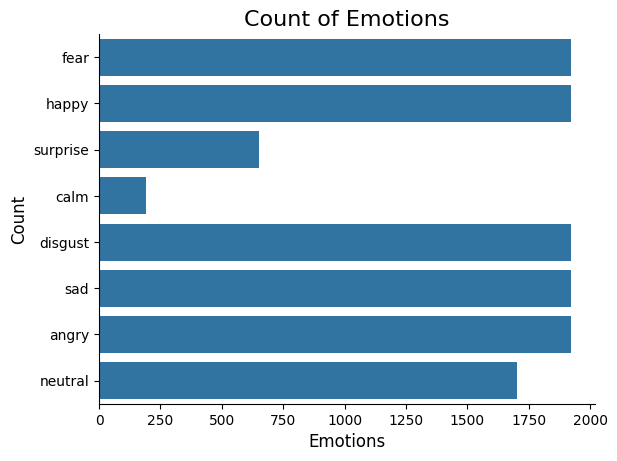

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [12]:
import matplotlib.pyplot as plt
import librosa.display

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)  # ✅ Use waveshow instead of waveplot
    plt.show()


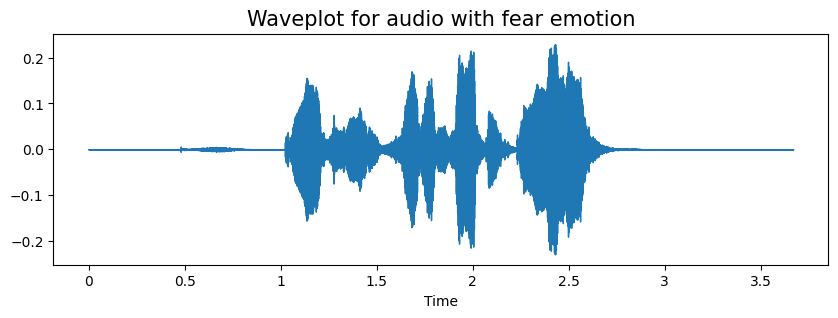

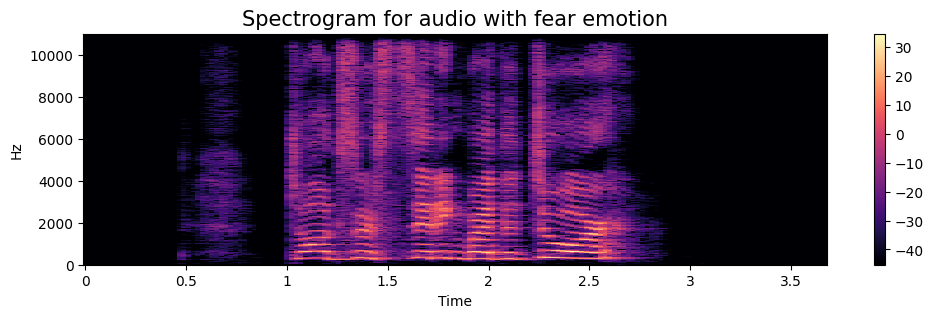

In [13]:
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path)

# Generate visualizations
create_waveplot(data, sampling_rate, emotion)  # ✅ Fixed function
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


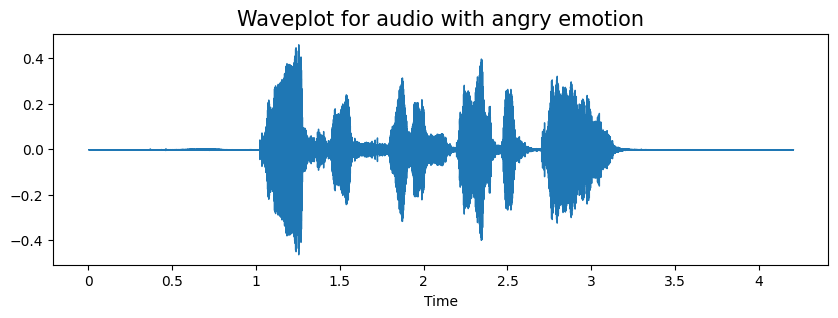

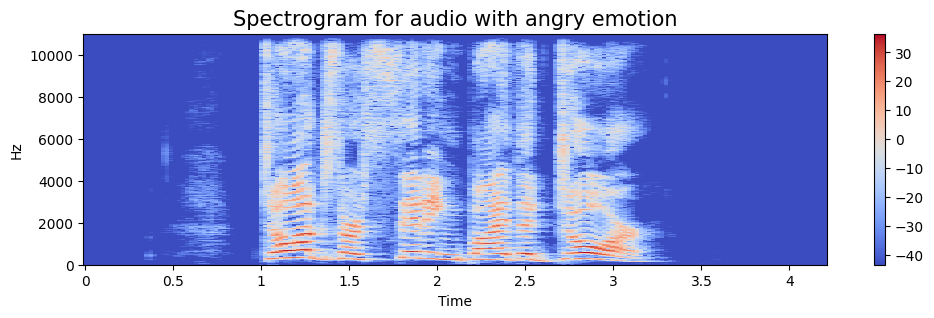

In [14]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

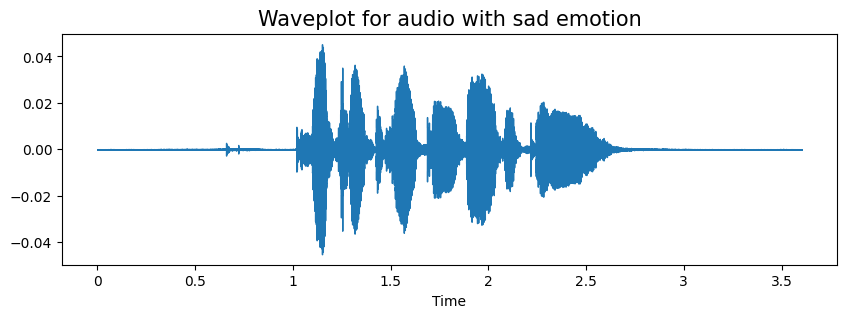

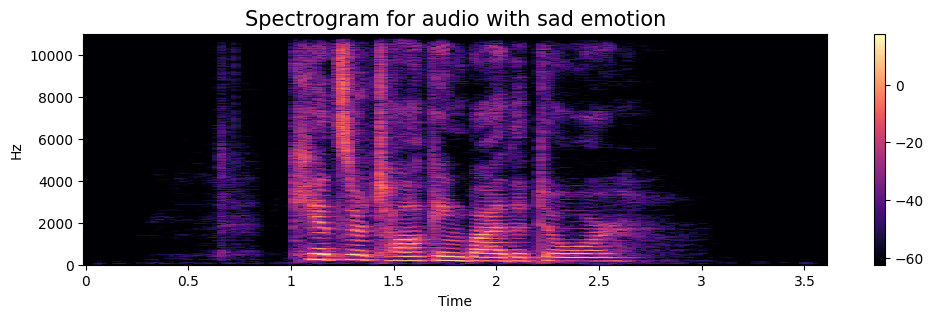

In [15]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

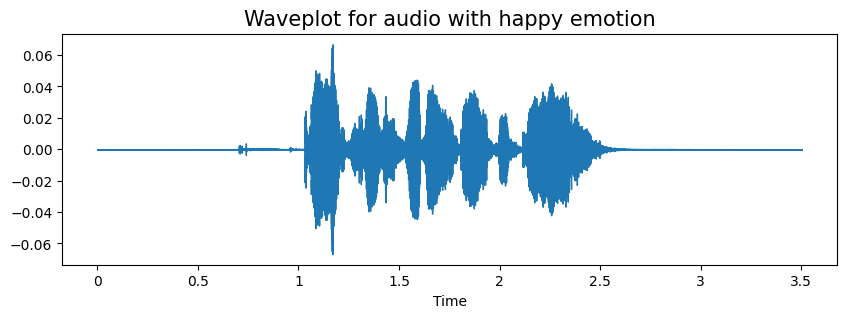

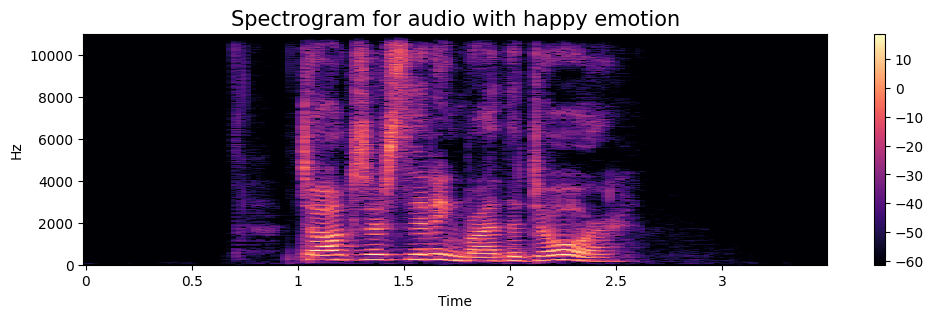

In [16]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [17]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    if len(data.shape) > 1:  # Convert stereo to mono if needed
        data = librosa.to_mono(data)

    # Ensure the length remains the same (important for padding)
    data = librosa.util.fix_length(data, size=int(len(data) / rate))

    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

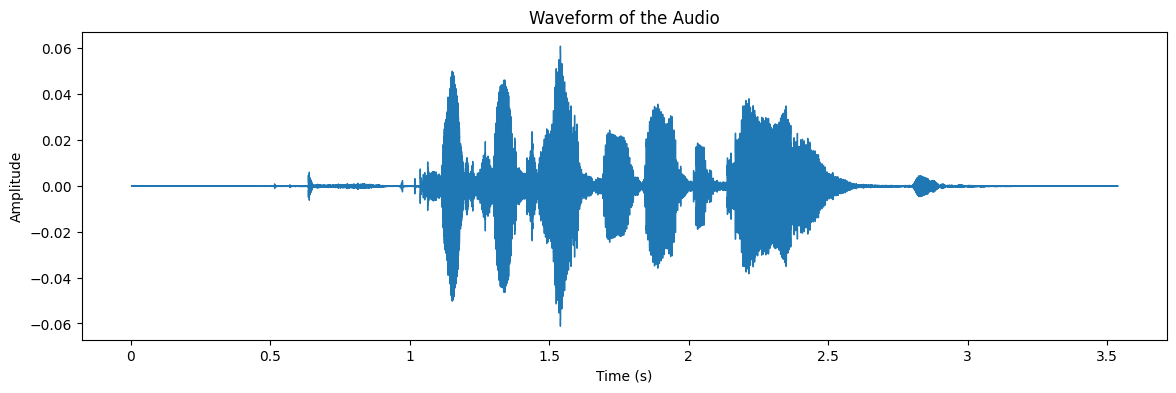

In [18]:
# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sampling_rate)  # ✅ Use waveshow instead of waveplot
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the audio
Audio(path)

#### 2. Noise Injection

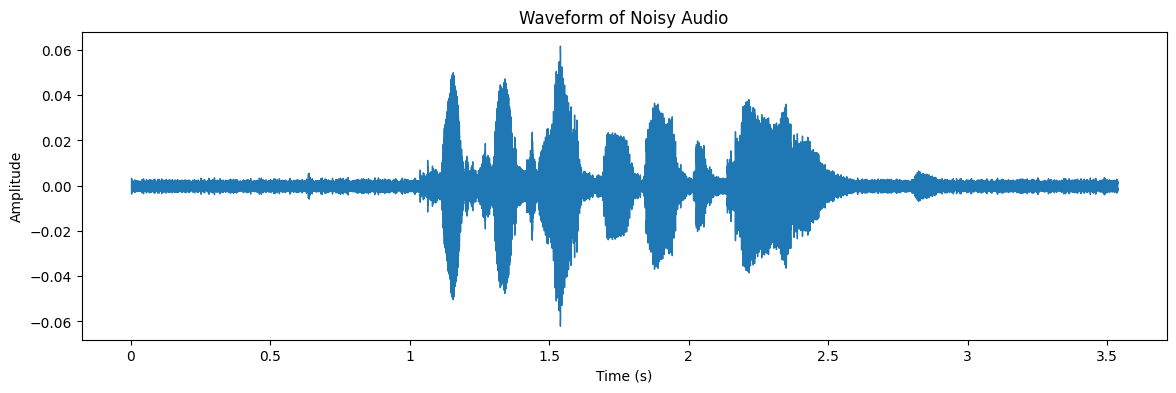

In [19]:
# Apply noise to the data (assuming noise function exists)
x = noise(data)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)  # ✅ Use waveshow
plt.title("Waveform of Noisy Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the noisy audio
Audio(data=x, rate=sampling_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

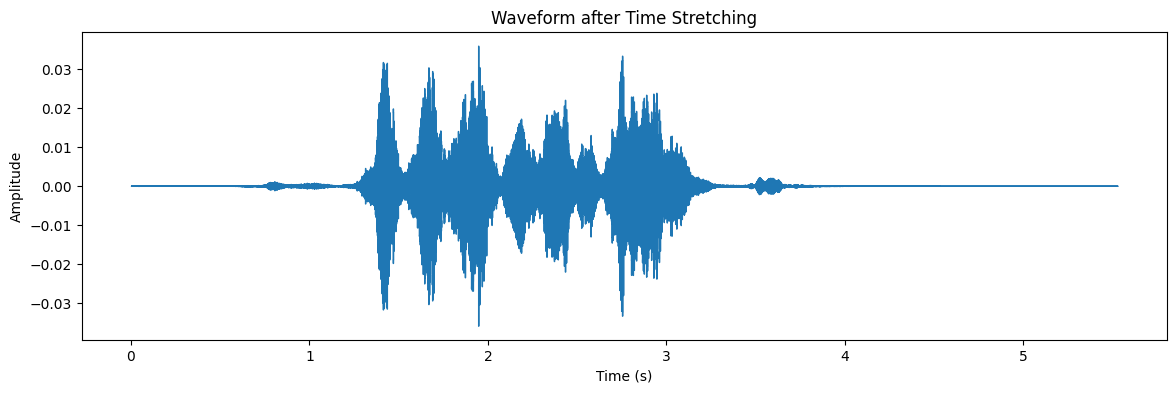

In [20]:
# Apply time-stretching
x = stretch(data)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)  # ✅ Use waveshow instead of waveplot
plt.title("Waveform after Time Stretching")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the modified audio
Audio(x, rate=sample_rate)


#### 4. Shifting

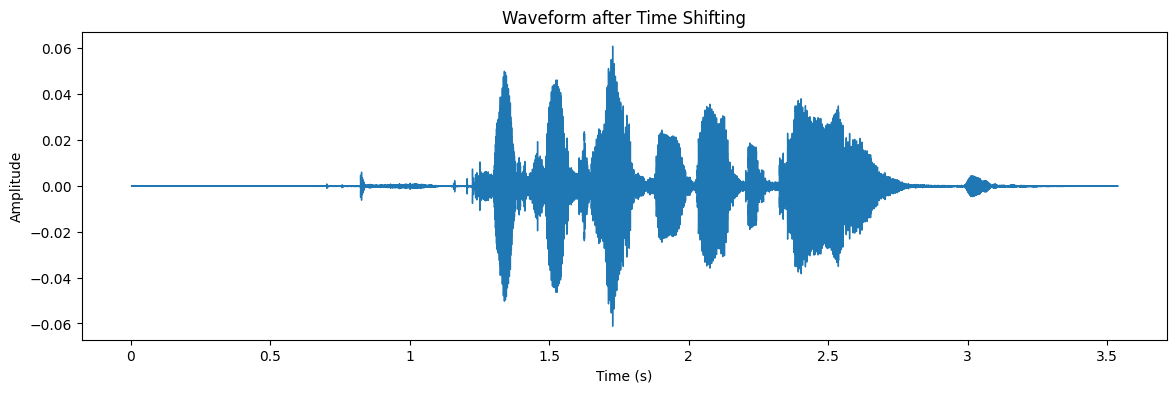

In [21]:
# Apply shifting
x = shift(data)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)  # ✅ Use waveshow()
plt.title("Waveform after Time Shifting")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the modified audio
Audio(x, rate=sample_rate)

#### 5. Pitch

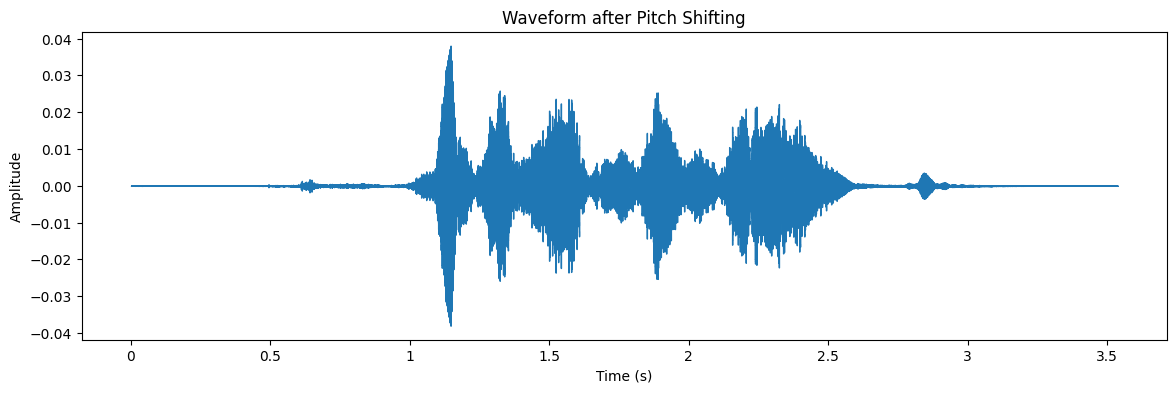

In [22]:
x = pitch(data, sample_rate)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)  # ✅ Use waveshow()
plt.title("Waveform after Pitch Shifting")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the modified audio
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [23]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [25]:
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.0 MB/s eta 0:00:00


In [26]:
from joblib import Parallel, delayed

def get_features(path):
    y, sr = librosa.load(path, sr=16000, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return [mfcc.mean(axis=1)]  # Reduce features

def process_file(path, emotion):
    features = get_features(path)
    return [(feature, emotion) for feature in features]

# Run in parallel
results = Parallel(n_jobs=-1)(delayed(process_file)(path, emotion) for path, emotion in zip(data_path.Path, data_path.Emotions))

# Flatten results
X, Y = zip(*[pair for result in results for pair in result])
X, Y = list(X), list(Y)


In [27]:
len(X), len(Y), data_path.Path.shape

(12162, 12162, (12162,))

In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0          1          2          3          4          5  \
0 -494.945374  22.528395 -27.147434   0.822328 -18.235868 -11.857844   
1 -619.776062  56.124405 -18.568159  10.313831  -6.354309  -4.232076   
2 -517.836060  37.648457 -24.918783   4.033931 -14.333838  -8.138819   
3 -680.509094  47.809948  -4.759385  12.274528  -6.995443  -0.864417   
4 -636.378113  45.901962 -13.177415   6.559729  -8.633522  -5.259603   

           6          7          8         9         10        11         12  \
0 -22.671675 -10.062975 -10.682393 -3.431231 -16.349440  1.735093 -10.604670   
1 -18.350544  -8.200959  -8.351087 -1.531613 -13.519156  1.226257  -9.212081   
2 -18.345142 -10.937547  -6.125208 -1.642260 -14.519324  1.818028 -11.061689   
3 -12.705894  -0.635719  -5.787510  0.975398 -11.107950  4.874990  -6.771430   
4 -18.732929  -9.164710  -7.553691 -0.140008 -12.991895  1.569897  -7.868763   

     labels  
0      fear  
1     happy  
2  surprise  
3      calm  
4     happy

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [29]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [30]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [31]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9121, 13), (9121, 8), (3041, 13), (3041, 8))

In [32]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9121, 13), (9121, 8), (3041, 13), (3041, 8))

In [33]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9121, 13, 1), (9121, 8), (3041, 13, 1), (3041, 8))

## Modelling

In [34]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 256)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 256)              │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 4, 128)              │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 64)               │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 536,808 (2.05 MB)

 Trainable params: 536,808 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.2030 - loss: 1.9417 - val_accuracy: 0.3246 - val_loss: 1.6476 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.3122 - loss: 1.6852 - val_accuracy: 0.3870 - val_loss: 1.4898 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.3622 - loss: 1.5644 - val_accuracy: 0.4413 - val_loss: 1.3936 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.4080 - loss: 1.4681 - val_accuracy: 0.4666 - val_loss: 1.3441 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.4466 - loss: 1.3874 - val_accuracy: 0.4633 - val_loss: 1.3238 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.4573 - loss: 1.3570 - val_accuracy: 0.4903 - val_loss: 1.2634 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.4796 - l

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5382 - loss: 1.8054
Accuracy of our model on test data :  53.27194929122925 %


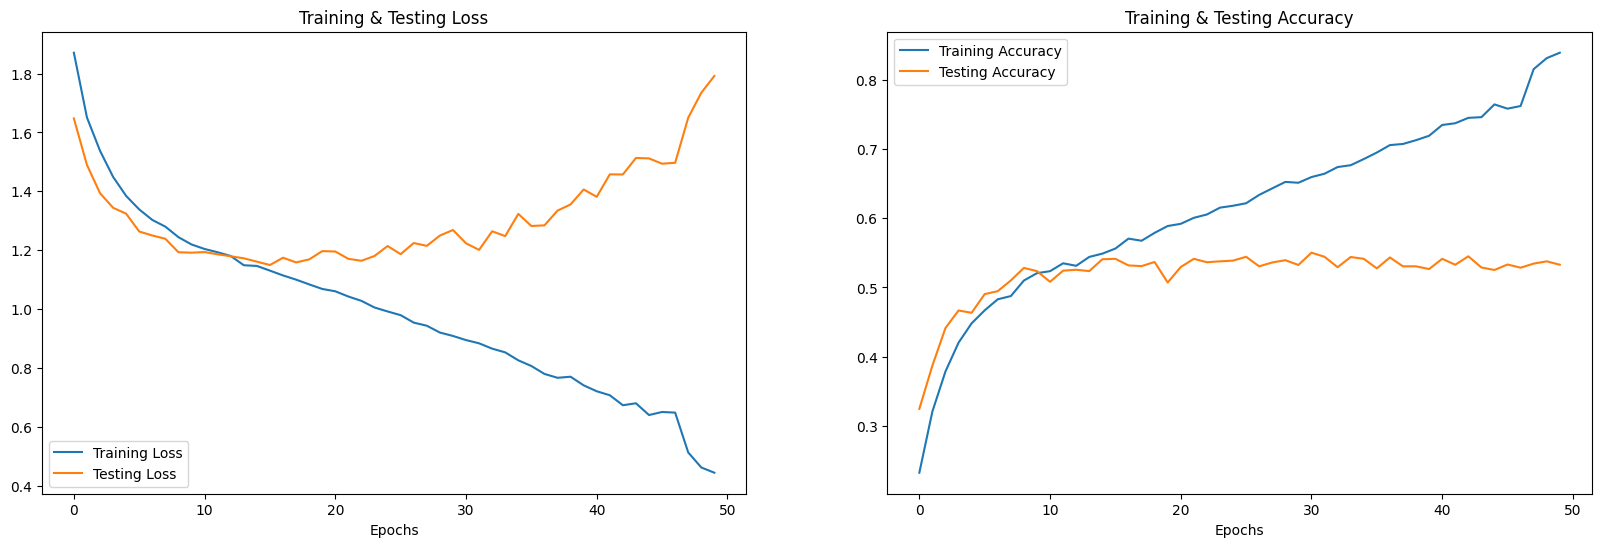

In [36]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [37]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [38]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1          disgust         angry
2             fear          fear
3              sad           sad
4          disgust       disgust
5            happy          fear
6            angry         angry
7          neutral       disgust
8              sad           sad
9         surprise      surprise

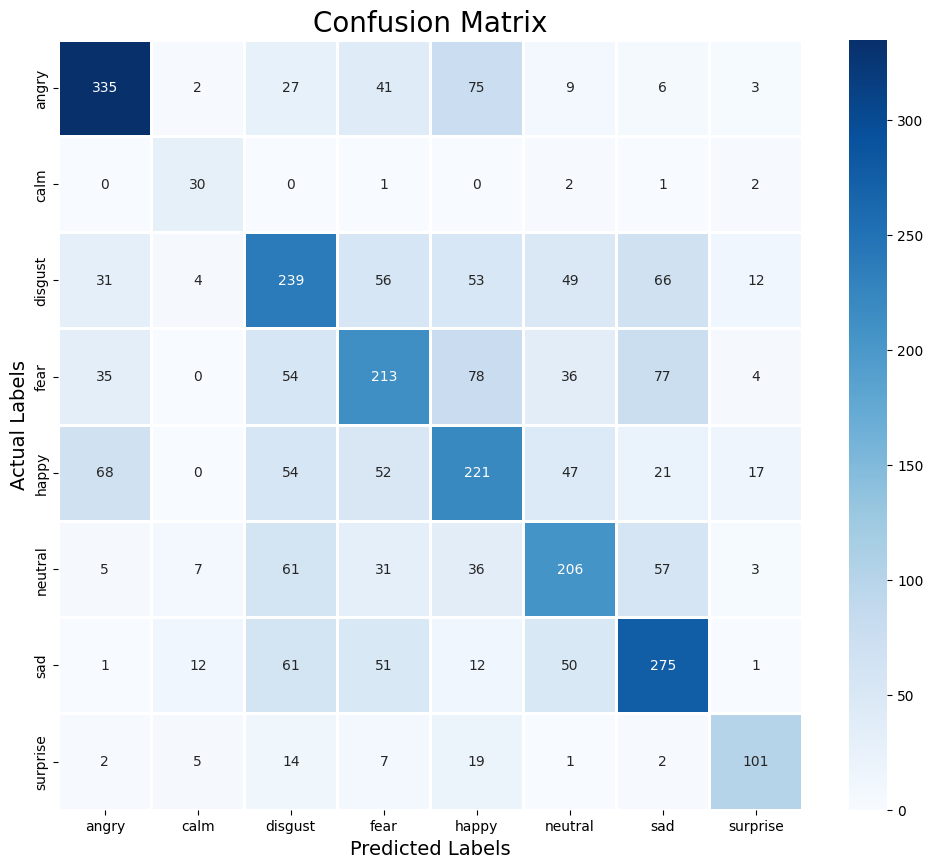

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.70      0.67      0.69       498
        calm       0.50      0.83      0.62        36
     disgust       0.47      0.47      0.47       510
        fear       0.47      0.43      0.45       497
       happy       0.45      0.46      0.45       480
     neutral       0.52      0.51      0.51       406
         sad       0.54      0.59      0.57       463
    surprise       0.71      0.67      0.69       151

    accuracy                           0.53      3041
   macro avg       0.54      0.58      0.56      3041
weighted avg       0.53      0.53      0.53      3041



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

In [41]:
model.save("emotion_recognition_model.h5")
print("Model saved successfully as 'emotion_recognition_model.h5'")


Model saved successfully as 'emotion_recognition_model.h5'


#Testing for IESC dataset
It is a hindi laanguage dataset

In [42]:
import zipfile

# Define the path to the zip file
zip_path = "/content/IESC_dataset.zip"
extract_path = "/content/IESC_dataset"  # Change this if needed

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed! Files are extracted to:", extract_path)


Unzipping completed! Files are extracted to: /content/IESC_dataset


In [49]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

In [50]:
dataset_path = "/content/IESC_dataset/Speaker-1/"  # Change to your dataset path
emotion_labels = ["Anger", "Fear", "Happy", "Neutral", "Sad"]

In [48]:
# Load trained model
model = load_model("/content/emotion_recognition_model.h5")  # Change this to your model's filename
